# Week2 作业

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

- 规律：x是一个五维向量，每个数乘以100000后，每个数字取一位作为加数，如第0个数，取个位，第1个数，取十位，第三个数，取百位，以此类推，相加之和模5，做一个5分类任务

In [2]:
class TorchModel(nn.Module):
    def __init__(self, input_size):
        super(TorchModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 10) 
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20, 30)
        self.layer4 = nn.Linear(30, 40)
        self.layer5 = nn.Linear(40, 30)
        self.layer6 = nn.Linear(30, 20)
        self.layer7 = nn.Linear(20, 10)
        self.layer8 = nn.Linear(10, input_size)          
        self.activation = nn.Softmax(dim=-1)      
        self.loss = nn.CrossEntropyLoss()         
        self.fc = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6, self.layer7, self.layer8, self.activation)
    def forward(self, x, y = None):
        y_pred = self.fc(x)
        if y is not None:
            return self.loss(y_pred, y)
        else:
            return y_pred

In [3]:
def getNumber(aNum, aInd):
    multiplier = 10 ** (5 - aInd)
    return int(aNum * multiplier) % 10

def getClassLabel(nums):
    weights = [getNumber(nums[i], i) for i in range(5)]
    return sum(weights) % 5
    
# 生成一个样本，样本的生成方法，代表了我们要学习的规律
def build_sample():
    x = np.random.random(5)
    return x, getClassLabel(x)

# 随机生成一批样本
def build_dataset(total_sample_num):
    X = []
    Y = []
    for i in range(total_sample_num):
        x, y = build_sample()
        X.append(x)
        Y.append([y])
    return torch.FloatTensor(X), torch.FloatTensor(Y)

In [4]:
# 测试代码，用来测试每轮模型的准确率
def evaluate(model):
    model.eval()
    test_sample_num = 100
    x,  y = build_dataset(test_sample_num)
    print(f"本次预测中，共有{(y == 0).sum().item()}个第0类样本，{(y == 1).sum().item()}个第1类样本，{(y == 2).sum().item()}个第2类样本，{(y == 3).sum().item()}个第3类样本，{(y == 4).sum().item()}个第4类样本")
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)
        for y_p, y_t in zip(y_pred, y):  # 与真实标签进行对比
            if int(np.argmax(y_p)) == int(y_t):
                correct += 1  # 判断正确
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f" % (correct, correct / (correct + wrong)))
    return correct / (correct + wrong)

In [5]:
def main():
    # 配置参数
    epoch_num = 200  # 训练轮数
    batch_size = 5  # 每次训练样本个数
    train_sample = 5000  # 每轮训练总共训练的样本总数
    input_size = 5  # 输入向量维度
    learning_rate = 0.001  # 学习率
    # 建立模型
    model = TorchModel(input_size)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 创建训练集，正常任务是读取训练集
    train_x, train_y = build_dataset(train_sample)
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch_index in range(train_sample // batch_size):
            x = train_x[batch_size * batch_index : batch_size * (batch_index + 1)]
            y = torch.flatten(train_y[batch_size * batch_index: batch_size * (batch_index + 1)]).long()
            loss = model(x, y)   # 计算损失
            loss.backward()      # 计算梯度
            optim.step()  # 更新权重
            optim.zero_grad()  # 梯度归零
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model)  # 测试本轮模型结果
        log.append([acc, float(np.mean(watch_loss))])
    # 保存模型
    torch.save(model.state_dict(), "model.pt")
    # 画图
    print(log)
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  # 画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  # 画loss曲线
    plt.legend()
    plt.show()
    return


In [6]:
# 使用训练好的模型做预测
def predict(model_path, input_vec):
    input_size = 5
    model = TorchModel(input_size)
    model.load_state_dict(torch.load(model_path))  # 加载训练好的权重
    print(model.state_dict())

    model.eval()  # 测试模式
    with torch.no_grad():  # 不计算梯度
        result = model.forward(torch.FloatTensor(input_vec))  # 模型预测
    for vec, res in zip(input_vec, result):
        max_ind = res.argmax()
        print(f"输入: {vec}, 预测类别: {max_ind}, 概率值: {res[max_ind]}") # 打印结果

C:\Users\gaius\AppData\Local\Temp\ipykernel_16832\3154606851.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.FloatTensor(X), torch.FloatTensor(Y)


第1轮平均loss:1.609860
本次预测中，共有22个第0类样本，24个第1类样本，23个第2类样本，13个第3类样本，18个第4类样本
正确预测个数：13, 正确率：0.130000
第2轮平均loss:1.609701
本次预测中，共有15个第0类样本，20个第1类样本，25个第2类样本，14个第3类样本，26个第4类样本
正确预测个数：15, 正确率：0.150000
第3轮平均loss:1.609611
本次预测中，共有17个第0类样本，21个第1类样本，18个第2类样本，25个第3类样本，19个第4类样本
正确预测个数：19, 正确率：0.190000
第4轮平均loss:1.609568
本次预测中，共有18个第0类样本，25个第1类样本，18个第2类样本，21个第3类样本，18个第4类样本
正确预测个数：17, 正确率：0.170000
第5轮平均loss:1.609539
本次预测中，共有27个第0类样本，18个第1类样本，20个第2类样本，15个第3类样本，20个第4类样本
正确预测个数：21, 正确率：0.210000
第6轮平均loss:1.609521
本次预测中，共有21个第0类样本，16个第1类样本，25个第2类样本，19个第3类样本，19个第4类样本
正确预测个数：17, 正确率：0.170000
第7轮平均loss:1.609500
本次预测中，共有19个第0类样本，22个第1类样本，22个第2类样本，14个第3类样本，23个第4类样本
正确预测个数：27, 正确率：0.270000
第8轮平均loss:1.609501
本次预测中，共有14个第0类样本，22个第1类样本，21个第2类样本，25个第3类样本，18个第4类样本
正确预测个数：18, 正确率：0.180000
第9轮平均loss:1.609507
本次预测中，共有22个第0类样本，16个第1类样本，24个第2类样本，16个第3类样本，22个第4类样本
正确预测个数：19, 正确率：0.190000
第10轮平均loss:1.609498
本次预测中，共有20个第0类样本，20个第1类样本，20个第2类样本，23个第3类样本，17个第4类样本
正确预测个数：18, 正确率：0.180000
第11轮平均loss:1.609456
本次预测中，共有22个第0类样本，16

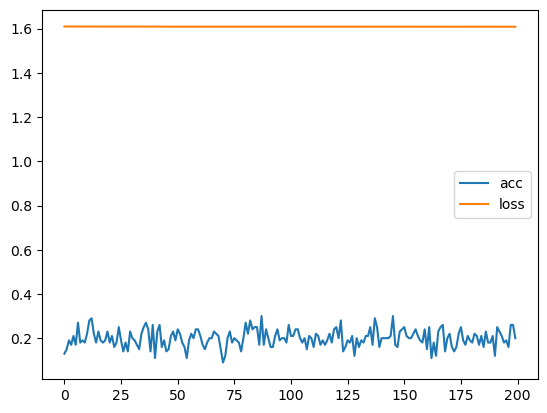

OrderedDict([('layer1.weight', tensor([[ 0.3225, -0.0320,  0.5957, -0.3257, -0.7453],
        [-0.7381, -0.1407, -0.3154, -0.0941,  1.2506],
        [ 0.1718, -0.0041,  0.5182, -0.0412, -0.9408],
        [-0.1357, -0.2307, -0.8103, -0.0995,  0.8874],
        [-0.0603,  0.0702, -0.0094,  0.0860, -0.0185],
        [ 0.0598, -0.0627,  0.0279, -0.0605,  0.0521],
        [-0.0629,  0.0613, -0.0242,  0.1037, -0.0587],
        [-0.2436, -0.0993, -0.5555,  0.2850,  0.3570],
        [ 0.0544, -0.0876,  0.0218, -0.0971,  0.0874],
        [ 0.0656, -0.0682,  0.0317, -0.0603,  0.0221]])), ('layer1.bias', tensor([ 0.2828,  0.0165,  0.3396,  0.1314, -0.0167, -0.0297,  0.0125, -0.0524,
        -0.0006, -0.0177])), ('layer2.weight', tensor([[ 9.1215e-02, -4.4483e-02, -1.7119e-01, -7.2003e-02,  2.1059e-01,
          3.3376e-03, -3.8777e-02,  1.0240e-01,  2.3891e-02, -3.8671e-01],
        [-1.9836e-01,  2.6992e-02,  2.0459e-01,  1.4807e-01,  1.0356e-01,
          7.8048e-02,  2.1589e-01, -2.2925e-01, -3

In [7]:
if __name__ == "__main__":
    main()
    test_vec = [[0.07889086,0.15229675,0.31082123,0.03504317,0.18920843],
                [0.94963533,0.5524256,0.95758807,0.95520434,0.84890681],
                [0.78797868,0.67482528,0.13625847,0.34675372,0.19871392],
                [0.19349776,0.59416669,0.92579291,0.41567412,0.7358894]]
    predict("model.pt", test_vec)